# 파이썬으로 배우는 기계학습
# Machine Learning with Python

# 제 12-1 강: Gradient Descent 2 - 미니배치 경사하강법

## 학습 목표
- 미니배치(Mini-Batch) 경하하강법을 학습한다.
- 다양한 경사하강법들의 차이점을 학습한다.
- 과대적합(Overfitting) 원인과 해결 방법을 학습한다.

## 학습 내용
- 미니배치(Mini-Batch) 경사하강법
- 경사하강법들의 장단점과 학습률
- 과대적합(Overfitting) 원인과 해결 방법
- 조기 종료
- 데이터 증식
- 드롭아웃

In [1]:
import imp
import joy
imp.reload(joy)
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## MNIST 미니배치 경사하강법 신경망의 구현

우리는 앞 강의에서 MNIST 데이터셋의 분류 문제를 다룰 수 있는 신경망에 대해 공부습니다.  이번에는 경사하강법을 좀 더 효율적으로 할 수 있는 확률적 경사하강법에 대해 알아 보겠습니다. 

## 1. 미니배치$^{mini-batch}$

확률적 경사하강법은 자료를 하나씩 처리합니다. 미니배치 경사하강법은 자료를 하나씩 처리하는 것이 아니라 한 묶음씩 처리합니다. 미니배치란 훈련자료의 일부를 무작위로 선택한 자료의 한 묶음을 말합니다.  반복적으로 이런 미니배치에 대해서 경사하강법으로 가중치를 갱신하며 학습하는 것을 확률적 경사하강법이라고 부릅니다. 

MNIST 데이터셋은 60,000개의 훈련자료가 있습니다.  이 모든 자료를 대상으로 손실함수의 합을 구하려면 시간이 걸리기도 하고 메모리가 부족하기도 합니다.  더 나아가 빅데이터 문제 같은데에서는 문제가 더 심각해집니다. 이 많은 자료를 각각 손실함수를 계산하는 것은 현실적이지 않습니다. 이 경우 자료의 일부를 추려 전체의 근사치로 이용할 수 있습니다.  신경망 학습에서도 훈련자료의 일부만을 무작위로 선택하여 한 묶음으로 학습을 수행합니다. 한 묶음의 자료를 미니배치$^{mini-batch}라고 합니다. 

예를 들면, 60,000장의 훈련자료 중에서 100장을 무작위로 선택하여 한 묶음으로 학습을 진행하는 것입니다. 이러한 학습방법을 미니배치 학습이라고 합니다. 

MNIST 데이터셋의 훈련자료에서 자료를 100개 무작위로 뽑아내는 코드를 작성해봅시다.  제일 먼저 MNIST 데이터셋을 읽어오는 코드를 작성해봅시다.  

In [3]:
(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
print('Xshape={}, y.shape={}'.format(X.shape, y.shape))

Xshape=(60000, 784), y.shape=(60000,)


위의 코드의 출력에서도 알 수 있듯이, 훈련자료의 이미지 형상과 레이블의 형상은 각각 (60000, 784), (60000,) 입니다.  테스트 자료의 이미지 형상과 레이블은 각각 (10000, 784), (10000, 1)입니다. 이러한 형상의 자료에서 우리는 무작위로, 예를 들면 100장을 선택하여 미니배치를 만들려고 한다면 어떻게 하면 될까요?

넘파이의 `np.random.choice()` 함수를 사용하면 다음과 같이 간단히 해결할 수 있습니다.  choice()는 지정된 수의 범위 내에서 무작위로 원하는 갯수의 자료를 복사해올 수 있습니다.  예를 들면, np.random.choice(60000, 5)을 호출하면, 0 에서 60000미만의 수 안에서 무작위로 5개를 선택해줍니다. random.choice() 함수가 출력한 배열을 미니배치에서 뽑아낼 자료의 인덱스로 사용하는 것입니다. 

자, 그러면 batch_size = 5로 설정하여, 코드를 한 번 실제로 실행해 보겠습니다. 

In [4]:
m_samples = X.shape[0]
batch_size = 8
batch_mask = np.random.choice(m_samples, batch_size)
xbatch = X[batch_mask]
ybatch = y[batch_mask]
print(ybatch)                  #[7 7 2 7 7] 
print(batch_mask)           #[34344  3798  41292  40681  30245]

[3 1 3 8 8 9 6 5]
[17621 45302 37756 17825 28065 48747 43925 33511]


미니배치로 선택한 이미지 자료를 시각화해볼 수도 있습니다. 단, 유의할 것은 load_mnist()함수로 가져온 자료는 훈련을 위한 자료이므로 이미지로 시각화하기 위해서는 형상을 조정해야 합니다. 현재 `batch_size = m`이라고 한다면, xbatch의 형상은 `(m, 768)`인데, 이를 이미지로 표현할 수 있는 `(m, 28, 28)`형상으로 `reshape`해야 합니다.  reshape의 인자 중에 -1은 28x28형상을 중심으로 먼저 조정하고 나머지는 reshape()에서 조정하라는 의미입니다. -1을 사용하는 방법으로 reshape 인자를 코딩을 하면, `batch_size = 16`으로 변할지라도 시각화 함수를 호출하는 다음 코드는 변경하지 않아도 됩니다. 

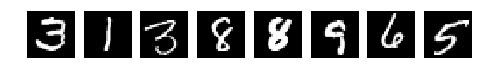

In [5]:
joy.show_mnist_grid(xbatch.reshape(-1, 28,28))

## 2. 미니배치 신경망 훈련 

미니배치를 이용한 신경망 훈련을 하기 전에, 우리가 바로 앞에서 구현하였던 MnistNet 클래스가 MNIST 데이터셋을 다루면서 

다음 그림1은 MnistNet클래스의 입출력 자료의 형상과 변수 , fit() 메소드가 호출하는 feedpass()메소드 부분의 연산을 보여주고 있습니다. MnistNet클래스에서는 훈련자료의 각 이미지로 신경망을 학습시키고 있다는 사실입니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/MnistSGDOutline.png?raw=true" width="600">
<center>그림 1: MnistMiniBatch 신경망의 구현(배치크기, m = ..., 8, 16, 32, ... )</center>

미니배치 경사하강법은 확률적 경사하강법과 달리 `m = 1`이 아니라 `m = batch_size`로 만들어 신경망을 학습시키는 방법입니다. 중요한 것은 이미 `MnistMiniBatch` 클래스의 fit 메소드에서 각 샘플을 하나씩 계산하지 않고 한 묶음씩 처리하는 것이며, 그 외에 다른 코드는 거의 같습니다.  미니배치에서 배치의 크기는 여러 옵션이 있겠지만, CPU/GPU 하드웨어와 메모리 구조를 생각해서 32의 배수 혹은 인수로 사용하는 것이 효과적이라고 합니다. 예를 들면, 8, 16, 32, 64, ... 등이 될 수 있을 것입니다.  

배치처리는 계산 속도를 상당히 향상시킵니다.  이미지 한장당 처리 시간을 대폭 감소시켜줍니다. 그 이유는 어디에 있을까요? 

첫째는 파이썬이나 혹은 관련된 수치 계산 라이브러리가 대부분 큰 배열을 효율적으로 처리할 수 있도록 최적화 되어 있기 때문입니다.  
둘째는 복잡한 신경망에서 속도에 대한 병목현상은 대부분 자료 전송에서 일어나는데, 배치형식으로 자료를 한번에 다량으로 (미니 배치로) 전달하는 방법은 그러한 자료 전송의 문제에 큰 도움이 됩니다. BUS(I/O)를 통해 자료를 읽는 속도보다 한번 많은 자료를 갖고 있어서 CPU/GPU의 연산 속도가 빨라질 수 밖에 없습니다.  작은 배열을 여러번 처리하는 것보다 많은 자료를 한번에 처리하는 것이 훨씬 빠르다는 것입니다. 


In [2]:
#%%writefile code/MnistMiniBatch.py
#%load code/MnistMiniBatch.py
class MnistMiniBatch(object):
    """ Mini-batch Gradient Descent
    """
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 100, batch_size = 32, random_seed=1):
        """ 
        """
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0)          # hidden layer inputs
        A1 = self.g(Z1)                      # hidden layer outputs/activation func
        Z2 = np.dot(self.W2, A1)          # output layer inputs
        A2 = self.g(Z2)                       # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        """ 
        X: input dataset 
        y: class labels
        """

        self.cost_ = []
        m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        #print('X.shape={}, y.shape={}, Y.shape={}'.format(X.shape, y.shape, Y.shape))
        
        for epoch in range(self.epochs):
            print('Training epoch {}/{}.'.format(epoch + 1, self.epochs))
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i: i + self.batch_size]
                Y0 = Y[i: i + self.batch_size]
                
                A0 = np.array(A0, ndmin=2).T
                Y0 = np.array(Y0, ndmin=2).T

                Z1, A1, Z2, A2 = self.forpass(A0)        

                E2 = Y0 - A2                 
                E1 = np.dot(self.W2.T, E2)       

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)     
                dZ1 = E1 * self.g_prime(Z1)    

                # update weights
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)    

                self.cost_.append(np.sqrt(np.sum(E2 * E2)
                                          /self.batch_size))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0)   # forpass
        return A2                                       

    def g(self, x):                             # activation_function: sigmoid
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):                    # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

In [3]:
e_list = [i for i in np.arange(1, 15)] + \
         [i for i in np.arange(20, 110, 15)]
e_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 35, 50, 65, 80, 95]

## Overfitting: Increased Epochs

In [ ]:
(X, y), (Xtest, ytest) = joy.load_mnist() 
epoch_list = [i for i in np.arange(1, 31, 2)] + \
             [i for i in np.arange(40, 101, 20)]
self_accuracy = []
test_accuracy = []
for i, e in  enumerate(epoch_list):
    nn = MnistMiniBatch(784, 100, 10, epochs = e, 
                        batch_size = 32)  
    nn.fit(X, y)  
    self_accuracy.append(nn.evaluate(X, y))  
    test_accuracy.append(nn.evaluate(Xtest, ytest))

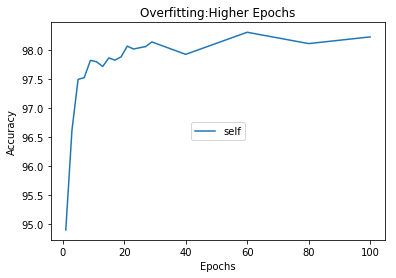

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.plot(epoch_list, self_accuracy, label='self')
#plt.plot(epoch_list, test_accuracy, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Epochs'
          .format(nn.batch_size))
plt.legend(loc='center')
plt.show()

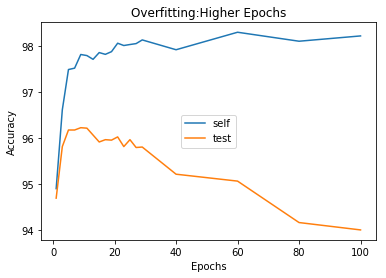

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.plot(epoch_list, self_accuracy, label='self')
plt.plot(epoch_list, test_accuracy, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Epochs'
          .format(nn.batch_size))
plt.legend(loc='center')
plt.show()

In [8]:
np.linspace(100, 500, 9, dtype=int)

array([100, 150, 200, 250, 300, 350, 400, 450, 500])

## Overfitting: Increased hidden neurons

In [7]:
(X, y), (Xtest, ytest) = joy.load_mnist() 
n_h_list = np.linspace(50, 800, 16, dtype=int)
self_accuracy = []
test_accuracy = []
for n_h in  n_h_list:
    nn = MnistMiniBatch(784, n_h, 10, 
                        epochs = 10, batch_size = 32)  
    nn.fit(X, y)  
    self_accuracy.append(nn.evaluate(X, y))  
    test_accuracy.append(nn.evaluate(Xtest, ytest))

n_h= 50
n_h= 100
n_h= 150
n_h= 200
n_h= 250
n_h= 300
n_h= 350
n_h= 400
n_h= 450
n_h= 500
n_h= 550
n_h= 600
n_h= 650
n_h= 700
n_h= 750
n_h= 800


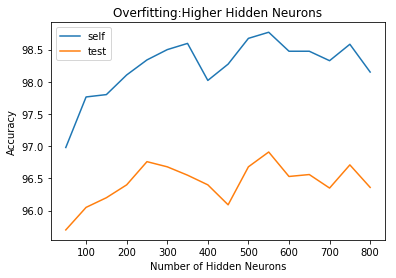

In [8]:
plt.plot(n_h_list, self_accuracy, label='self')
plt.plot(n_h_list, test_accuracy, label='test')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Hidden Neurons')
plt.legend(loc='best')
plt.show()

## 5. MnistMiniBatch fit() 메소드

다음 코드는 `fit()`메소드에서 다른 경사하강법들과 다른 점은 미니배치를 아래와 같이 설정하는 부분입니다. 
 
```
        for epoch in range(self.epochs):
            print('Training epoch {}/{}.'.format(epoch + 1, self.epochs))
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i : i + self.batch_size]
                Y0 = Y[i : i + self.batch_size]    
```
`batch_size`는 사용자가 신경망 클래스 객체를 처음 생성할 때에 신경망의 속성으로 설정합니다. 디폴트로는 32로 초기화되어 있습니다.  매번 신경망을 학습시킬 때에 미니크기로 훈련자료를 차례대로 한 단위로 묶어 입력하여 기울기를 계산하고 오차를 계산하여 매개변수 가중치를 갱신하는 과정입니다. 

`for-loop`에서 주어진 훈련자료와 레이블 `m_samples`를 `batch_size`로 잘라서 차례대로 입력 `A0`, 출력 `Y0` 설정하여 연산을 진행합니다. 이것이 전부입니다. 정말 단순한 방법이지만 속도와 메모리 사용이 효율적이 됩니다.   

### 6.3 오차(self.cost_)의 시각화 

신경망을 학습시키면서 발생하는 오차(손실)가 MnistMiniBatch 클래스 객체의 속성 `cost_`에 저장되어 있습니다. 이를 시각화해서 신경망이 어떻게 학습을 하였는지, 손실을 최소화하는 방향을 수렴하였는지 분석할 수 있습니다.  다음 셀의 코드를 실행해 봅시다.  

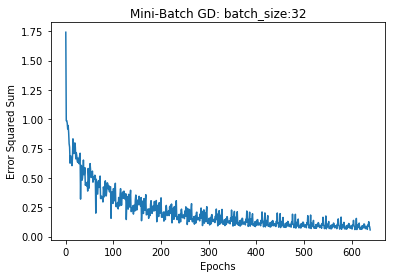

In [44]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title('Mini-Batch GD: batch_size:{}'
          .format(nn.batch_size))
plt.show()

In [32]:
def fit(self, X, y): 
    self.cost_ = []
    m_samples = len(y)
    Y = joy.one_hot_encoding(y, self.n_y)    
    for epoch in range(self.epochs):            
        for i in range(0, m_samples, self.batch_size):
            A0 = X[i: i + self.batch_size]
            Y0 = Y[i: i + self.batch_size]
            A0 = np.array(X[m], ndmin=2).T   
            Y0 = np.array(Y[m], ndmin=2).T     
            Z1 = np.dot(self.W1, A0)      
            A1 = self.g(Z1)             
            Z2 = np.dot(self.W2, A1)    
            A2 = self.g(Z2)         

            E2 = Y0 - A2                     
            E1 = np.dot(self.W2.T, E2)       
            dZ2 = E2 * self.g_prime(Z2)        
            dZ1 = E1 * self.g_prime(Z1)   
            dW2 = np.dot(dZ2, A1.T) 
            dW1 = np.dot(dZ1, A0.T)   
            self.W2 += self.eta * dW2/self.batch_size
            self.W1 += self.eta * dW1/self.batch_size 
            self.cost_.append(np.sqrt(np.sum(E2 * E2))
                              /self.batch_size)
    return self

## Mnist  MiniBatchGD


In [3]:
#%%writefile code/MnistMiniBatch.py
#%load code/MnistMiniBatch.py
class MnistMiniBatchGD(object):
    """ Mini-batch Gradient Descent
    """
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 100, batch_size = 32, random_seed=1):
        """ 
        """
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0, train=True):
        Z1 = np.dot(self.W1, A0)          # hidden layer inputs
        A1 = self.g(Z1)                      # hidden layer outputs/activation func
        '''
        # Dropout
        if train:
            self.drop_units = np.random.rand(*A1.shape) > self.dropout_ratio
            A1 = A1 * self.drop_units
        else:
            A1 = A1 * (1.0 - self.dropout_ratio)
        '''
           
        Z2 = np.dot(self.W2, A1)          # output layer inputs
        A2 = self.g(Z2)                       # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        """ 
        X: input dataset 
        y: class labels
        """

        self.cost_ = []
        m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        #print('X.shape={}, y.shape={}, Y.shape={}'.format(X.shape, y.shape, Y.shape))
        
        for epoch in range(self.epochs):
            print('Training epoch {}/{}.'.format(epoch + 1, self.epochs))
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i: i + self.batch_size]
                Y0 = Y[i: i + self.batch_size]
                
                A0 = np.array(A0, ndmin=2).T
                Y0 = np.array(Y0, ndmin=2).T

                Z1, A1, Z2, A2 = self.forpass(A0)        

                E2 = Y0 - A2                 
                E1 = np.dot(self.W2.T, E2)       

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)     
                dZ1 = E1 * self.g_prime(Z1)    
                '''
                # Dropout
                dZ1 = dZ1 * self.drop_units       
                '''
                
                # update weights
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)    

                self.cost_.append(np.sqrt(np.sum(E2 * E2)
                                          /self.batch_size))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0, train=False)   # forpass
        return A2                                       

    def g(self, x):                             # activation_function: sigmoid
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):                    # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

In [5]:
import joy
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = MnistMiniBatchGD(784, 600, 10, epochs = 40)
nn.fit(X[:3000], y[:3000])
self = nn.evaluate(X[:3000], y[:3000])
test = nn.evaluate(Xtest[:1000], ytest[:1000])
print('MNIST self accuracy {}%'.format(self))
print('MNIST test accuracy {}%'.format(test))

MNIST self accuracy 100.0%
MNIST test accuracy 89.3%


# KMOOC Final Exam 

## Accuracy of Each Digit

- get the histogram of each digit in the label `ytest`
- get the yhat of test dataset
- compare the output `yhat` and the label `ytest` to compute the accuracy 

In [1]:
import joy
import numpy as np
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = joy.MnistMiniBatchGD(784, 200, 10, epochs = 10)
nn.fit(X, y)
self_accuracy = nn.evaluate(X, y)
test_accuracy = nn.evaluate(Xtest, ytest)
print('Test accuracy {}%'.format(np.round(test_accuracy, 2)))

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Training epoch 1/10.
Training epoch 2/10.
Training epoch 3/10.
Training epoch 4/10.
Training epoch 5/10.
Training epoch 6/10.
Training epoch 7/10.
Training epoch 8/10.
Training epoch 9/10.
Training epoch 10/10.
Test accuracy 96.36%


In [4]:
histo = np.bincount(ytest)
print(histo)

[ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [12]:
# Compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)
truth = []
for i in np.arange(10):
    count = ___ (___ for h, y in zip(yhat, ytest) if i == h == y)
    truth.append(count)
print('Digit Accuracy:', np.round(truth/histo, 2))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 2))

Digit Accuracy: [0.99 0.99 0.94 0.97 0.98 0.95 0.97 0.95 0.95 0.94]
Total Accuracy: 0.96


In [10]:
# Compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)
truth = []
for i in np.arange(10):
    count = sum(1 for h, y in zip(yhat, ytest) if i == h == y)
    truth.append(count)
print('Digit Accuracy:', np.round(truth/histo, 3))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 3))


print('Highest Accuracy:', np.argmax(truth/histo))
print('Lowest  Accuracy:', np.argmin(truth/histo))

Digit Accuracy: [0.989 0.994 0.943 0.969 0.979 0.954 0.966 0.949 0.955 0.94 ]
Total Accuracy: 0.964
Highest Accuracy: 1
Lowest  Accuracy: 9


In [9]:
# to compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)

truth = []
for i in np.arange(10):  # for each digit
    count = 0
    for hat, y in zip(yhat, ytest): 
        if i == hat == y: 
            count += 1
    truth.append(count)

print('Digit Accuracy:', np.round(truth/histo, 3))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 3))

Digit Accuracy: [0.989 0.994 0.943 0.969 0.979 0.954 0.966 0.949 0.955 0.94 ]
Total Accuracy: 0.964


# MNIST-Mini-BatchGD_Dropout

In [6]:
#%%writefile code/MnistMiniBatch.py
#%load code/MnistMiniBatch.py
class MnistMiniBatchGD_Dropout(object):
    """ Mini-batch Gradient Descent with Dropout
    """
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 100, batch_size = 32, random_seed=1, dropout_ratio=0.5):
        """ 
        """
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        np.random.seed(random_seed)
        self.dropout_ratio = dropout_ratio
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0, train=True):
        Z1 = np.dot(self.W1, A0)                # hidden layer inputs
        A1 = self.g(Z1)                         # hidden layer outputs/activation func

        # Dropout
        if train:
            self.drop_units = np.random.rand(*A1.shape) > self.dropout_ratio
            A1 = A1 * self.drop_units / self.dropout_ratio
          
        Z2 = np.dot(self.W2, A1)                # output layer inputs
        A2 = self.g(Z2)                         # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        """ 
        X: input dataset 
        y: class labels
        """

        self.cost_ = []
        m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        #print('X.shape={}, y.shape={}, Y.shape={}'.format(X.shape, y.shape, Y.shape))
        
        for epoch in range(self.epochs):
            #print('Training epoch {}/{}.'.format(epoch + 1, self.epochs))
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i: i + self.batch_size].T
                Y0 = Y[i: i + self.batch_size].T
                Z1, A1, Z2, A2 = self.forpass(A0)        

                E2 = Y0 - A2                 
                E1 = np.dot(self.W2.T, E2)       

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)     
                dZ1 = E1 * self.g_prime(Z1)    

                # Dropout
                dZ1 = dZ1 * self.drop_units       

                # update weights
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)    

                self.cost_.append(np.sqrt(np.sum(E2 * E2)
                                          /self.batch_size))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0, train=False)   # forpass
        return A2                                       

    def g(self, x):                             # activation_function: sigmoid
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):                    # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

In [7]:
import joy
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = MnistMiniBatchGD_Dropout(784, 600, 10, 
            epochs = 40, dropout_ratio = 0.5)
nn.fit(X[:3000], y[:3000])
self = nn.evaluate(X[:3000], y[:3000])
test = nn.evaluate(Xtest[:1000], ytest[:1000])
print('MNIST self accuracy {}%'.format(self))
print('MNIST test accuracy {}%'.format(test))

MNIST self accuracy 99.73333333333333%
MNIST test accuracy 91.7%


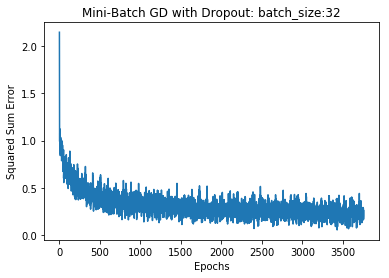

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum Error')
plt.title('Mini-Batch GD with Dropout: batch_size:{}'
          .format(nn.batch_size))
plt.show()

## 학습 정리
- 미니배치(Mini-Batch) 경사하강법을 학습하기
- 학습 스케줄링
- 과대적합의 원인과 해결 방법
- 조기 종료
- 데디터 증식
- 드롭아웃

-------------------

_For God so loved the world that he gave his one and only Son, that whoever believes in him shall not perish but have eternal life. John3:16_